# Setup

In [21]:
# Download dependencies
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary

from pathlib import Path
import os

import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.0+cu118


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Transforming data

In [23]:
# Set path to data
data_path = Path("../data")
image_path = data_path / "b200c-lego-classification-dataset"

image_path_list = list(image_path.glob("*/*.jpg"))

class_names = os.listdir(image_path)

image_path, class_names

(WindowsPath('../data/b200c-lego-classification-dataset'),
 ['10247',
  '11090',
  '11211',
  '11212',
  '11214',
  '11458',
  '11476',
  '11477',
  '14704',
  '14719',
  '14769',
  '15068',
  '15070',
  '15100',
  '15207',
  '15379',
  '15392',
  '15535',
  '15573',
  '15712',
  '18651',
  '18654',
  '18674',
  '18677',
  '20482',
  '22388',
  '22885',
  '2357',
  '2412b',
  '2420',
  '24201',
  '24246',
  '2429',
  '2430',
  '2431',
  '2432',
  '2436',
  '2445',
  '2450',
  '2454b',
  '2456',
  '24866',
  '25269',
  '2540',
  '26047',
  '2654',
  '26601',
  '26603',
  '26604',
  '2780',
  '27925',
  '28192',
  '2877',
  '3001',
  '3002',
  '3003',
  '3004',
  '3005',
  '3008',
  '3009',
  '3010',
  '30136',
  '3020',
  '3021',
  '3022',
  '3023',
  '3024',
  '3031',
  '3032',
  '3034',
  '3035',
  '3037',
  '30374',
  '3039',
  '3040b',
  '30414',
  '3062b',
  '3065',
  '3068b',
  '3069b',
  '3070b',
  '32000',
  '32013',
  '32028',
  '32054',
  '32062',
  '32064a',
  '32073',
  '321

In [25]:
# Write transforms for image
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=16),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Get transforms from the transfered model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [26]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431373..2.4285715].


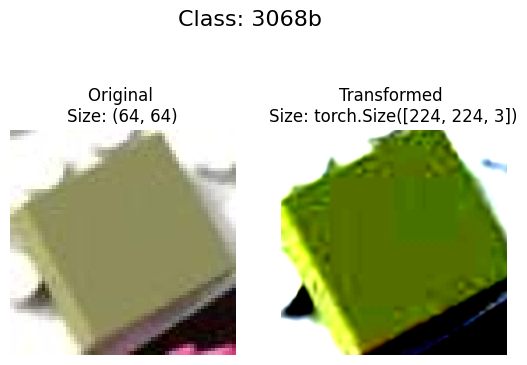

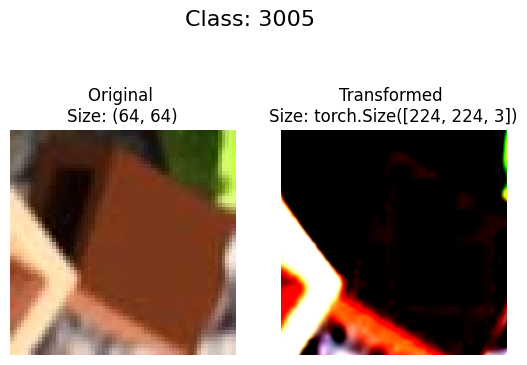

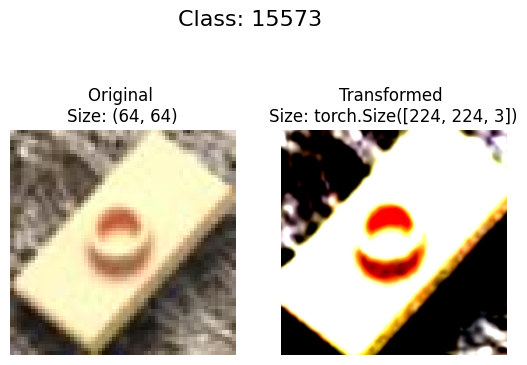

In [27]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=auto_transforms,
    n=3,
    seed=None
)

In [28]:
# Make data folder into dataset
full_dataset = datasets.ImageFolder(root=image_path,
                                  transform=auto_transforms,
                                  target_transform=None)

# Split into training and testing data
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_data, test_data = random_split(full_dataset, [train_size, test_size])

print(f"{len(train_data)}\n{len(test_data)}")

640000
160000


In [29]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Make dataset into dataloader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x16573b74040>,
 <torch.utils.data.dataloader.DataLoader at 0x16573b76dd0>)

# Build model

In [30]:
# Transfer a model (efficientnet_b0)
efficientnet_b0 = torchvision.models.efficientnet_b0(weights=weights).to(device)
#efficientnet_b0

In [31]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficientnet_b0.features.parameters():
    param.requires_grad = False

In [32]:
len(full_dataset.classes), len(train_dataloader.dataset)

(200, 640000)

In [33]:
# Get the length of class_names (one output unit for each class)
output_shape = len(full_dataset.classes)

# Recreate the classifier layer and seed it to the target device
efficientnet_b0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [36]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=efficientnet_b0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 200]            --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [50]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=efficientnet_b0.parameters(), lr=0.001)

# Train model

In [58]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(tqdm(dataloader, position=0, leave=True)):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [59]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [60]:
# Make the trainingloop
EPOCHS = 1

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

for epoch in range(EPOCHS):
    train_loss, train_acc = train_step(model=efficientnet_b0,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    
    test_loss, test_acc = test_step(model=efficientnet_b0, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
    )

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [21:07<00:00, 15.78it/s]


Epoch: 1 | train_loss: 3.0947 | train_acc: 0.2592 | test_loss: 2.5622 | test_acc: 0.3509
